# CSE 6240 - Web Search and Text Mining (Project 1)
## submitted by Bhanu Verma (903151012) and Nilaksh Das (903129996)

#### Setting up packages

In [59]:
import os
import math
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.stats import truncnorm
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import lil_matrix, linalg
from sklearn.decomposition import TruncatedSVD

In [2]:
%matplotlib inline

#### Importing data

In [3]:
categories = ["Animal",
              "Fungus",
              "Geological Formation",
              "Person",
              "Plant, flora, plant life",
              "Sport"]

IMAGES = {category: [] for category in categories}

X = {}
labels = []

n_images = 0

X["Images"] = []

for category in categories:
    folder_name = "Data/" + category
    file_count  = 0
    file_names  = os.listdir(folder_name)
    
    for file_name in file_names:
        image = Image.open(os.path.join(folder_name, file_name))
        image = image.resize((256, 256))
        image = image.convert("RGB")

        X["Images"].append(image)
        labels.append(category)
        
        n_images   += 1
        file_count += 1
        
        if (file_count % 500 == 0): print "Imported %d/%d files from %s" % (file_count, len(file_names), folder_name)
    print "Imported %d/%d files from %s" % (file_count, len(file_names), folder_name)

Imported 500/1571 files from Data/Animal
Imported 1000/1571 files from Data/Animal
Imported 1500/1571 files from Data/Animal
Imported 1571/1571 files from Data/Animal
Imported 500/1207 files from Data/Fungus
Imported 1000/1207 files from Data/Fungus
Imported 1207/1207 files from Data/Fungus
Imported 500/1808 files from Data/Geological Formation
Imported 1000/1808 files from Data/Geological Formation
Imported 1500/1808 files from Data/Geological Formation
Imported 1808/1808 files from Data/Geological Formation
Imported 500/1242 files from Data/Person
Imported 1000/1242 files from Data/Person
Imported 1242/1242 files from Data/Person
Imported 500/1271 files from Data/Plant, flora, plant life
Imported 1000/1271 files from Data/Plant, flora, plant life
Imported 1271/1271 files from Data/Plant, flora, plant life
Imported 500/1888 files from Data/Sport
Imported 1000/1888 files from Data/Sport
Imported 1500/1888 files from Data/Sport
Imported 1888/1888 files from Data/Sport


In [4]:
label_dict   = {category: index for index, category in enumerate(categories)}
labels_index = np.array([label_dict[label] for label in labels])

#### Flattened RGB Representation
This vector representation simply concatenates the R, G and B channels of the image.

In [6]:
def getFlattenedRGB(image):
    image_source = image.split()
    
    R, G, B = 0, 1, 2
    
    image_red   = np.asarray(image_source[R]).flatten()
    image_green = np.asarray(image_source[G]).flatten()
    image_blue  = np.asarray(image_source[B]).flatten()
    
    v = np.array([])
    
    v = np.append(v, [image_red, image_green, image_blue]).tolist()
    
    return v

In [7]:
X["Flattened RGB Representation"] = []

image_count = 0

print "Building dataset..."
for image in X["Images"]:
        X["Flattened RGB Representation"].append(getFlattenedRGB(image))
        
        image_count += 1

        if (image_count % 500 == 0): print "Added %d/%d images to dataset" % (image_count, n_images)
print "Added %d/%d images to dataset" % (image_count, n_images)

Building dataset...
Added 500/8987 images to dataset
Added 1000/8987 images to dataset
Added 1500/8987 images to dataset
Added 2000/8987 images to dataset
Added 2500/8987 images to dataset
Added 3000/8987 images to dataset
Added 3500/8987 images to dataset
Added 4000/8987 images to dataset
Added 4500/8987 images to dataset
Added 5000/8987 images to dataset
Added 5500/8987 images to dataset
Added 6000/8987 images to dataset
Added 6500/8987 images to dataset
Added 7000/8987 images to dataset
Added 7500/8987 images to dataset
Added 8000/8987 images to dataset
Added 8500/8987 images to dataset
Added 8987/8987 images to dataset


In [9]:
X["Flattened RGB Representation"] = np.array(X["Flattened RGB Representation"])

print X["Flattened RGB Representation"].shape

(8987, 196608)


#### Flattened Intensity Representation
This vector representation constitutes of the greyscale intensities of the image.

In [10]:
def getFlattenedIntensities(image):
    return np.array(image.convert("L"), dtype = float).T.flatten().tolist()

In [11]:
X["Flattened Intensity Representation"] = []

image_count = 0

print "Building dataset..."
for image in X["Images"]:
        X["Flattened Intensity Representation"].append(getFlattenedIntensities(image))
        
        image_count += 1

        if (image_count % 500 == 0): print "Added %d/%d images to dataset" % (image_count, n_images)
print "Added %d/%d images to dataset" % (image_count, n_images)

Building dataset...
Added 500/8987 images to dataset
Added 1000/8987 images to dataset
Added 1500/8987 images to dataset
Added 2000/8987 images to dataset
Added 2500/8987 images to dataset
Added 3000/8987 images to dataset
Added 3500/8987 images to dataset
Added 4000/8987 images to dataset
Added 4500/8987 images to dataset
Added 5000/8987 images to dataset
Added 5500/8987 images to dataset
Added 6000/8987 images to dataset
Added 6500/8987 images to dataset
Added 7000/8987 images to dataset
Added 7500/8987 images to dataset
Added 8000/8987 images to dataset
Added 8500/8987 images to dataset
Added 8987/8987 images to dataset


In [12]:
X["Flattened Intensity Representation"] = np.array(X["Flattened Intensity Representation"])

print X["Flattened Intensity Representation"].shape

(8987, 65536)


#### Alternate Representation
- divide `d1 x d1 x 3` tensor of each image into blocks of `d2 x d2 x 3` tensors, where `d1 % d2 = 0`

- convert each `d2 x d2 x 3` tensor into a flattened matrix of dimensions `d x 3`, `d = d2 x d2`

- for each window `w` in the `(d1/d2) x (d1/d2)` space, collect all corresponding `d x 3` matrices from all `n` images and concatenate them to form a matrix of dimensions `m x 3`, `m = n x d`. This essentially encapsulates the range of colors possible within a particular window `w` among all images.

- from the `m` instances of RGB values, find `k` representative RGB values. This will yield a dictionary matrix of `k x 3` dimensions for the particular window `w`. There will be `(d1/d2) x (d1/d2)` such dictionaries.

- to construct the features of each image, determine the "bag of words" for each window `w` by finding the representative RGB each pixel belongs to. This will yield `k` scalar values for each window. Concatenate the vectors of length `k` made up of the "bag of words" for each window of the image to obtain the feature representation of the image. This will be a vector of length `k x (d1/d2) x (d1/d2)`.

- tuning `d2` will determine how much spatial information we preserve; tuning `k` will determine how much chromatic information we preserve.

In [65]:
def divideImageIntoBlocks(image, d2):
    d1, d1 = image.size
    
    blocks = {}
    
    for i in range(d1/d2):
        for j in range(d1/d2):
            left   = j * d2
            top    = i * d2
            right  = ((j + 1) * d2)
            bottom = ((i + 1) * d2)
            
            blocks[(i, j)] = image.crop((left, top, right, bottom))
            
    return blocks

In [66]:
def flattenBlock(block):
    block_source = block.split()
    
    R, G, B = 0, 1, 2
    
    block_red   = np.asarray(block_source[R]).flatten().tolist()
    block_green = np.asarray(block_source[G]).flatten().tolist()
    block_blue  = np.asarray(block_source[B]).flatten().tolist()
    
    return np.matrix(zip(block_red, block_green, block_blue))

In [67]:
def trainFeatureConstructors(d1, d2, k):
    blocks = {}
    
    image_count = 0
    
    def appendImageBlocks(image):
        blocks_image = divideImageIntoBlocks(image, d2)
        
        for index in blocks_image:
            flattennedBlock = flattenBlock(blocks_image[index])
            
            if (index not in blocks): blocks[index] = flattennedBlock
            else: blocks[index] = np.concatenate((blocks[index], flattennedBlock))

    
    print "Dividing images into blocks..."
    for image in X["Images"]:
        appendImageBlocks(image)
        
        image_count += 1
        
        if (image_count % 500 == 0):
            print "Processed %d/%d images" % (image_count, n_images)
    print "Processed %d/%d images" % (image_count, n_images)
    
    
    predictors = {}

    def findCentroidsForBlockIndex(index):
        predictor = KMeans(n_clusters = k,
                           n_init = 4,
                           precompute_distances = True,
                           n_jobs = -1)
        
        predictor.fit(blocks[index])
        
        predictors[index] = predictor
        
    for index in blocks: findCentroidsForBlockIndex(index)
    print "Ran K-Means on every block"

    return predictors

In [73]:
def constructFeatures(image, predictors, d1, d2, k):
    features = np.array([], dtype = int)
    
    blocks = divideImageIntoBlocks(image, d2)
    
    for i in range(d1/d2):
        for j in range(d1/d2):
            assignments = predictors[(i, j)].predict(flattenBlock(blocks[(i, j)]).astype(float))

            block_features = [0] * k

            for assignment in assignments: block_features[assignment] += 1

            features = np.concatenate((features, np.array(block_features, dtype = int)))
        
    return features.tolist()

In [69]:
predictors = trainFeatureConstructors(256, 32, 48)

Dividing images into blocks...
Processed 500/8987 images
Processed 1000/8987 images
Processed 1500/8987 images
Processed 2000/8987 images
Processed 2500/8987 images
Processed 3000/8987 images
Processed 3500/8987 images
Processed 4000/8987 images
Processed 4500/8987 images
Processed 5000/8987 images
Processed 5500/8987 images
Processed 6000/8987 images
Processed 6500/8987 images
Processed 7000/8987 images
Processed 7500/8987 images
Processed 8000/8987 images
Processed 8500/8987 images
Processed 8987/8987 images
Ran K-Means on every block


In [74]:
X["Alternate Representation"] = []

image_count = 0

print "Building dataset..."
for image in X["Images"]:
        X["Alternate Representation"].append(constructFeatures(image, predictors, 256, 32, 48))
        
        image_count += 1

        if (image_count % 500 == 0): print "Added %d/%d images to dataset" % (image_count, n_images)
print "Added %d/%d images to dataset" % (image_count, n_images)

Building dataset...
Added 500/8987 images to dataset
Added 1000/8987 images to dataset
Added 1500/8987 images to dataset
Added 2000/8987 images to dataset
Added 2500/8987 images to dataset
Added 3000/8987 images to dataset
Added 3500/8987 images to dataset
Added 4000/8987 images to dataset
Added 4500/8987 images to dataset
Added 5000/8987 images to dataset
Added 5500/8987 images to dataset
Added 6000/8987 images to dataset
Added 6500/8987 images to dataset
Added 7000/8987 images to dataset
Added 7500/8987 images to dataset
Added 8000/8987 images to dataset
Added 8500/8987 images to dataset
Added 8987/8987 images to dataset


In [75]:
X["Alternate Representation"] = np.array(X["Alternate Representation"])

print X["Alternate Representation"].shape

(8987, 3072)


---
## Question 2

### Question 2.1

#### Autoencoder Encoded Representation

An auto-encoder, auto-associator or Diabolo network is an artificial neural network used for learning efficient codings. The aim of an auto-encoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Recently, the auto-encoder concept has become more widely used for learning generative models of data.

Architecturally, the simplest form of an auto-encoder is a feedforward, non-recurrent neural net which is very similar to the multilayer perceptron (MLP), with an input layer, an output layer and one or more hidden layers connecting them. The differences between auto-encoders and MLPs, though, are that in an auto-encoder, the output layer has the same number of nodes as the input layer, and that, instead of being trained to predict the target value Y given inputs X, auto-encoders are trained to reconstruct their own inputs X. Therefore, auto-encoders are unsupervised learning models.

[ref: https://en.wikipedia.org/wiki/Autoencoder]

In [13]:
def trainAutoencoder(X, num_hidden_neurons):
    input_data = np.array(X, dtype = float)

    scaled_input_data = np.divide((input_data - input_data.min(axis = 0)),
                                  (input_data.max(axis = 0) - input_data.min(axis = 0)))
    scaled_input_data = (2 * scaled_input_data) - 1

    idata = scaled_input_data
    odata = scaled_input_data

    n_samples, n_input_neurons = idata.shape
    n_hidden_neurons           = num_hidden_neurons

    graph = tf.Graph()

    with graph.as_default():
        print "Starting autoencoder training..."
        
        sess = tf.Session()

        x = tf.placeholder("float", [None, n_input_neurons])

        Wh = tf.Variable(
                tf.random_uniform(
                    (n_input_neurons, n_hidden_neurons),
                    -1.0 / math.sqrt(n_input_neurons),
                    +1.0 / math.sqrt(n_input_neurons)))
        bh = tf.Variable(tf.zeros([n_hidden_neurons]))
        h  = tf.nn.tanh(tf.matmul(x, Wh) + bh)

        Wo = tf.transpose(Wh)
        bo = tf.Variable(tf.zeros([n_input_neurons]))
        y  = tf.nn.tanh(tf.matmul(h, Wo) + bo)

        y_ = tf.placeholder("float", [None, n_input_neurons])

        mean_sq_error = tf.reduce_mean(tf.square(y_ - y))

        train_step = tf.train.GradientDescentOptimizer(0.05).minimize(mean_sq_error)

        init = tf.initialize_all_variables()
        sess.run(init)

        n_iterations = 25
        batch_size = min(1000, n_samples)

        for i in range(n_iterations):
            sample = np.random.randint(n_samples, size = batch_size)

            batch_xs = idata[sample][:]
            batch_ys = odata[sample][:]

            sess.run(train_step, feed_dict = {x: batch_xs, y_: batch_ys})

            if ((i + 1) % 4 == 0):
                print "Ran {0}/{1} iterations, mean sq. error = {2}".format(
                    i + 1, n_iterations,
                    sess.run(mean_sq_error, feed_dict = {x: batch_xs, y_: batch_ys}))
                
    print "Finished training autoencoder weights!"
    
    encoded_representation = sess.run(h, feed_dict = {x: idata})
    reconstructed_dataset  = sess.run(y, feed_dict = {x: idata})
    
    return encoded_representation, reconstructed_dataset

In [14]:
X["Encoded Representation"], X_reconstructed = trainAutoencoder(X["Flattened Intensity Representation"], 576)

Starting autoencoder training...
Ran 4/24 iterations, mean sq. error = 0.285024523735
Ran 8/24 iterations, mean sq. error = 0.272399067879
Ran 12/24 iterations, mean sq. error = 0.27295383811
Ran 16/24 iterations, mean sq. error = 0.270468354225
Ran 20/24 iterations, mean sq. error = 0.279940545559
Ran 24/24 iterations, mean sq. error = 0.276664376259
Finished training autoencoder weights!


In [15]:
X["Encoded Representation"] = np.array(X["Encoded Representation"])

print X["Encoded Representation"].shape

(8987, 576)


Let us now visually inspect an image and its encoded representation...

[]

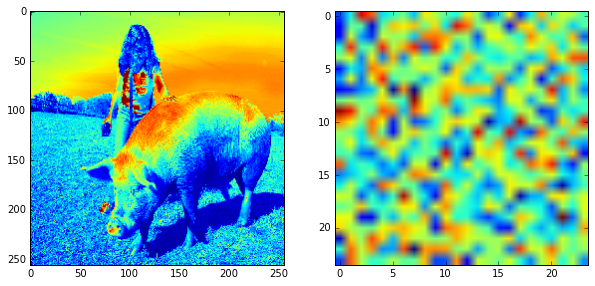

In [24]:
i = 42

test_img_intensities   = np.array(X["Flattened Intensity Representation"][i])
test_img_intensities   = test_img_intensities.reshape((256, 256), order = "F")

test_img_encoded       = np.array(X["Encoded Representation"][i])
test_img_encoded       = test_img_encoded.reshape((24, 24), order = "F")

plt.figure(figsize = (10, 7))

plt.subplot(1, 2, 1)
plt.imshow(test_img_intensities)

plt.subplot(1, 2, 2)
plt.imshow(test_img_encoded)

plt.plot()

As can be seen, the encoded representation on the right cannot be interpreted visually in a trivial manner. However, since it can be used to reconstruct the same values it was passed, it does encapsulate higher order features of the image.

### Question 2.2

#### SVD Reduced Representation

Calculating the SVD consists of finding the eigenvalues and eigenvectors of `AA'` and `A'A`. The eigenvectors of `A'A` make up the columns of `V`, the eigenvectors of `AA'` make up the columns of `U`. Also, the singular values in `S` are square roots of eigenvalues from `AA'` or `A'A`. The singular values are the diagonal entries of the `S` matrix and are arranged in descending order. The singular values are always real numbers. If the matrix `A` is a real matrix, then `U` and `V` are also real.

In [64]:
svd = TruncatedSVD(n_components = 512)

X["SVD Reduced Representation"] = svd.fit_transform(X["Flattened RGB Representation"])

print X["SVD Reduced Representation"].shape

(8987, 512)


### Question 2.3 (a)

Let us first see how the histograms for color and greyscale images look like.

[]

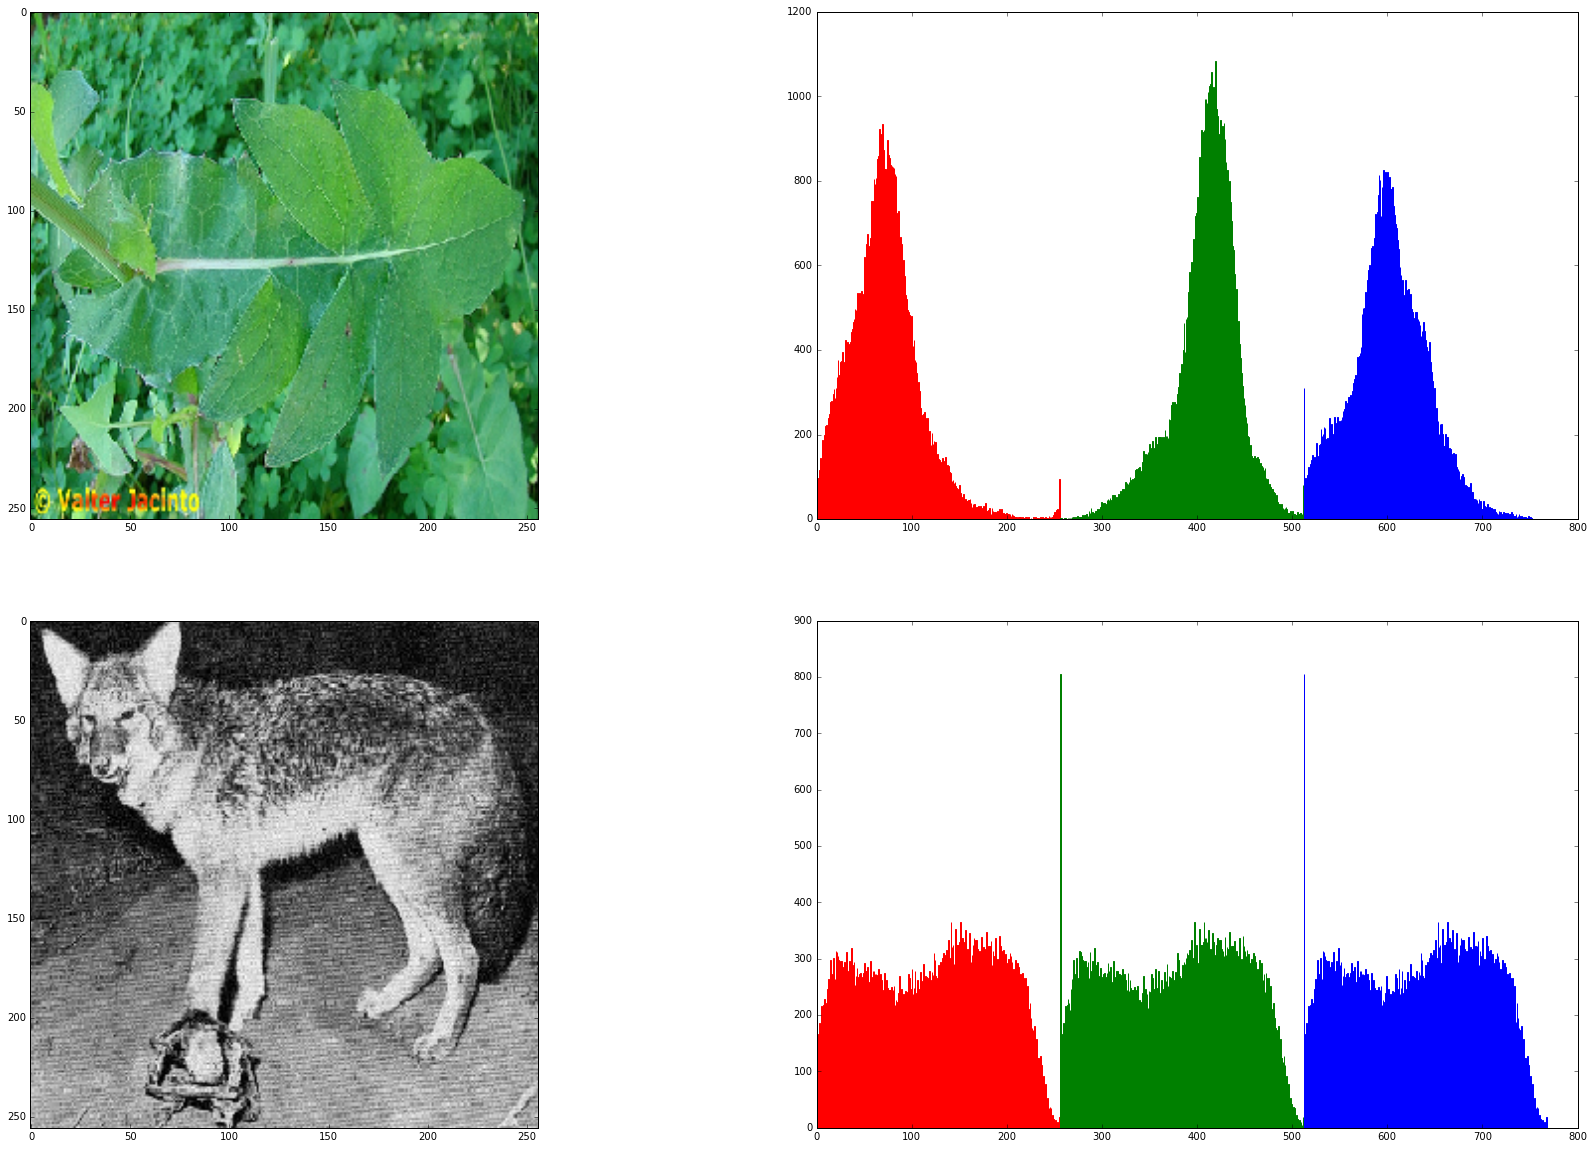

In [38]:
image1 = Image.open("Data/Plant, flora, plant life/n00017222_2763.JPEG")
image1 = image1.resize((256, 256))
image1 = image1.convert("RGB")

image2 = Image.open("Data/Animal/n00015388_45209.JPEG")
image2 = image2.resize((256, 256))
image2 = image2.convert("RGB")

plt.figure(figsize = (30, 20))

plt.subplot(2, 2, 1)
plt.imshow(image1)

plt.subplot(2, 2, 2)
bar1 = plt.bar(range(768), image1.histogram())

plt.subplot(2, 2, 3)
plt.imshow(image2)

plt.subplot(2, 2, 4)
bar2 = plt.bar(range(768), image2.histogram())

for i in range(768):
    if (i < 256):
        bar1[i].set_color('r')
        bar2[i].set_color('r')
    elif (i < 512):
        bar1[i].set_color('g')
        bar2[i].set_color('g')
    else:
        bar1[i].set_color('b')
        bar2[i].set_color('b')

plt.plot()

#### RGB Histogram Representation

In [39]:
X["RGB Histogram Representation"] = []

image_count = 0

print "Building dataset..."
for image in X["Images"]:
        X["RGB Histogram Representation"].append(image.histogram())
        
        image_count += 1

        if (image_count % 500 == 0): print "Added %d/%d images to dataset" % (image_count, n_images)
print "Added %d/%d images to dataset" % (image_count, n_images)

Building dataset...
Added 500/8987 images to dataset
Added 1000/8987 images to dataset
Added 1500/8987 images to dataset
Added 2000/8987 images to dataset
Added 2500/8987 images to dataset
Added 3000/8987 images to dataset
Added 3500/8987 images to dataset
Added 4000/8987 images to dataset
Added 4500/8987 images to dataset
Added 5000/8987 images to dataset
Added 5500/8987 images to dataset
Added 6000/8987 images to dataset
Added 6500/8987 images to dataset
Added 7000/8987 images to dataset
Added 7500/8987 images to dataset
Added 8000/8987 images to dataset
Added 8500/8987 images to dataset
Added 8987/8987 images to dataset


In [40]:
X["RGB Histogram Representation"] = np.array(X["RGB Histogram Representation"])

print X["RGB Histogram Representation"].shape

(8987, 768)


#### HSV Histogram Representation

In [41]:
X["HSV Histogram Representation"] = []

image_count = 0

print "Building dataset..."
for image in X["Images"]:
        X["HSV Histogram Representation"].append(image.convert("HSV").histogram())
        
        image_count += 1

        if (image_count % 500 == 0): print "Added %d/%d images to dataset" % (image_count, n_images)
print "Added %d/%d images to dataset" % (image_count, n_images)

Building dataset...
Added 500/8987 images to dataset
Added 1000/8987 images to dataset
Added 1500/8987 images to dataset
Added 2000/8987 images to dataset
Added 2500/8987 images to dataset
Added 3000/8987 images to dataset
Added 3500/8987 images to dataset
Added 4000/8987 images to dataset
Added 4500/8987 images to dataset
Added 5000/8987 images to dataset
Added 5500/8987 images to dataset
Added 6000/8987 images to dataset
Added 6500/8987 images to dataset
Added 7000/8987 images to dataset
Added 7500/8987 images to dataset
Added 8000/8987 images to dataset
Added 8500/8987 images to dataset
Added 8987/8987 images to dataset


In [42]:
X["HSV Histogram Representation"] = np.array(X["HSV Histogram Representation"])

print X["HSV Histogram Representation"].shape

(8987, 768)


---
## Question 3

#### Rating Representation

In [60]:
users = [x for x in range(1000)]
u_c_mat = lil_matrix((len(users), len(X["Images"])), dtype=np.float64)
img_ind = 0
mean_arr = []
sizeArr = [1571, 1207, 1808, 1242, 1271, 1888]
cumSizeArr = [1571, 2778, 4586, 5828, 7099, 8987]

for user in users:
    catChoiceArr = list(np.random.choice(6,4,replace=False))
    catChoiceArr.sort()
    choiceInd = 0
    for catInd,catPath in enumerate(categories):
        if choiceInd >= 4:
            break
        if catChoiceArr[choiceInd] == catInd:
            if catInd == 0:
                img_ind = 0
            else:
                img_ind = cumSizeArr[catInd-1]
            cat_mean = np.random.uniform(1.5,4.5)
            m = np.random.geometric(p=0.1,size=1)%sizeArr[catInd] 
            img_indices = list(np.random.choice(sizeArr[catInd],m,replace=False))
            for i,movie_ind in enumerate(img_indices):
                ind_val = img_ind + movie_ind
                rating = truncnorm.rvs(a=(1-cat_mean)/1,b=(5-cat_mean)/1,loc=cat_mean,scale=1)
                u_c_mat[user,ind_val] = rating
            choiceInd += 1

In [61]:
u,s,v = linalg.svds(u_c_mat)

In [63]:
X["Rating Representation"] = np.transpose(v)

print X["Rating Representation"].shape

(8987, 6)


---
## Question 4

In [94]:
def getEuclideanDistances(mat):
    y = pdist(mat, metric = "euclidean")
    
    euc_mat = squareform(y)
    
    return euc_mat

In [95]:
def getPearsonCoeffs(mat):
    return np.ma.corrcoef(mat)

In [96]:
def get5NearestEuclideanNeighbours(dist_mat):
    knn = []
    
    for row in range(dist_mat.shape[0]):
        nn = np.argsort(dist_mat[row])
        
        knn.append(nn[1:6])
    
    return np.array(knn)

In [97]:
def get5NearestPearsonNeighbours(dist_mat):
    knn = []
    
    for row in range(dist_mat.shape[0]):
        nn = np.argsort(dist_mat[row])[::-1]
        
        knn.append(nn[1:6])
    
    return np.array(knn)

In [98]:
def getMajorityVote(knn):
    pred = []
    
    for nn in knn:
        votes = labels_index[nn]
        
        counts = np.bincount(votes)
        
        pred.append(np.argmax(counts))

    return pred

In [99]:
def determineConfusionMatrix(pred):
    return confusion_matrix(labels_index, pred, labels = [0, 1, 2, 3, 4, 5])

In [100]:
def plotConfusionMatrix(cm, title = "Confusion Matrix"):
    tick_labels = ["Animal","Fungus","Geo","Person","Plant","Sport"]
    
    plt.figure()
    
    plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categories))
    plt.xticks(tick_marks, tick_labels, rotation = 45)
    plt.yticks(tick_marks, tick_labels)
    plt.tight_layout()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    
    plt.show()

In [101]:
def evaluateRepresentationWithEuclideanDistances(X_mat):
    pred = getMajorityVote(
            get5NearestEuclideanNeighbours(
             getEuclideanDistances(X_mat)))
    
    cm = determineConfusionMatrix(pred)
    accuracy = accuracy_score(labels_index, pred)
    
    print "Accuracy of majority vote = {0}".format(accuracy)
    print
    print "Confusion Matrix:"
    print cm
    
    plotConfusionMatrix(cm)

In [102]:
def evaluateRepresentationWithPearsonCoeffs(X_mat):
    pred = getMajorityVote(
            get5NearestPearsonNeighbours(
             getPearsonCoeffs(X_mat)))
    
    cm = determineConfusionMatrix(pred)
    accuracy = accuracy_score(labels_index, pred)
    
    print "Accuracy of majority vote = {0}".format(accuracy)
    print
    print "Confusion Matrix:"
    print cm
    
    plotConfusionMatrix(cm)

### Confusion Matrices

A confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice-versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

#### Autoencoder - Euclidean Distances

Accuracy of majority vote = 0.277734505397

Confusion Matrix:
[[ 565   33  694   78  142   59]
 [ 313  105  498   70  187   34]
 [ 339   15 1278   57   77   42]
 [ 345   49  573  178   68   29]
 [ 352   56  538   84  210   31]
 [ 687   17  802   73  149  160]]


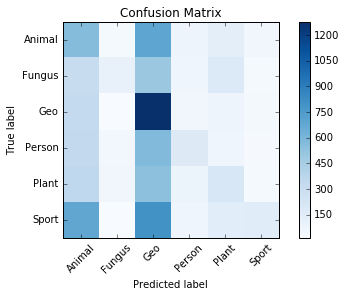

In [103]:
evaluateRepresentationWithEuclideanDistances(X["Encoded Representation"])

#### Autoencoder - Pearson Coefficients

Accuracy of majority vote = 0.47546455992

Confusion Matrix:
[[ 839   76  311  262   31   52]
 [ 129  573  226  219   40   20]
 [ 173   66 1366  145   16   42]
 [ 141   54  308  704   15   20]
 [ 207  175  307  312  241   29]
 [ 305  101  483  401   48  550]]


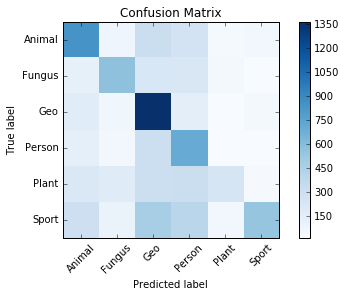

In [104]:
evaluateRepresentationWithPearsonCoeffs(X["Encoded Representation"])

It can be seen that the encoded representation does not give much accuracy with simple euclidean distances but scores high on correlation coefficients. This result reinforces the fact that the autoencoder learns higher order non-linear features.

#### SVD - Euclidean Distances

Accuracy of majority vote = 0.585067319461

Confusion Matrix:
[[ 900   95  254   36  147  139]
 [ 149  734  119   20  133   52]
 [ 130   75 1467   20   41   75]
 [ 231  145  258  427   71  110]
 [ 119  150  172   25  749   56]
 [ 234   94  411   34  134  981]]


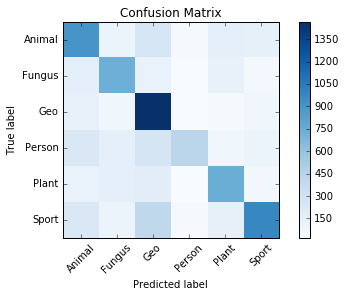

In [113]:
evaluateRepresentationWithEuclideanDistances(X["SVD Reduced Representation"])

#### SVD - Pearson Coefficients

Accuracy of majority vote = 0.572938689218

Confusion Matrix:
[[ 910   72  270   48  133  138]
 [ 181  656  178   17  129   46]
 [ 104   53 1511   21   41   78]
 [ 239  118  324  404   50  107]
 [ 164  132  195   17  715   48]
 [ 265   68  459   49   94  953]]


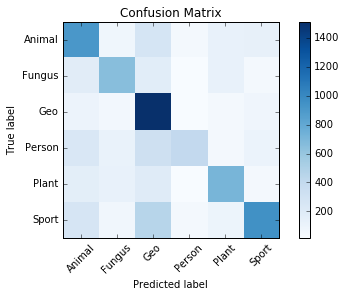

In [114]:
evaluateRepresentationWithPearsonCoeffs(X["SVD Reduced Representation"])

While doing Truncated SVD, we experimented with a number of components, namely 128, 256, 512 and 1024 but accuracy results did not show any significant deviations. One reasoning for this can be that number for principal components for this matrix are even less than 128 and hence, results didn’t change much for using any number of components higher than the number of principal components.

#### RGB Histogram - Euclidean Distances

Accuracy of majority vote = 0.361410926894

Confusion Matrix:
[[525 415 277 107 173  74]
 [223 713  77  44 120  30]
 [423 353 778  86 111  57]
 [279 376 151 312  58  66]
 [244 346 133  40 480  28]
 [474 450 266 139 119 440]]


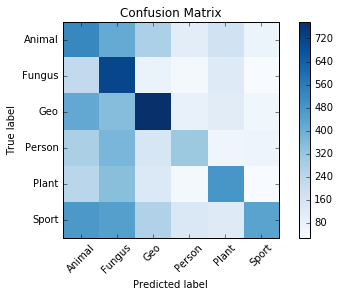

In [105]:
evaluateRepresentationWithEuclideanDistances(X["RGB Histogram Representation"])

#### RGB Histogram - Pearson Coefficients

Accuracy of majority vote = 0.563480583064

Confusion Matrix:
[[ 950  206  185   83  113   34]
 [ 156  852   69   41   75   14]
 [ 247  197 1205   62   53   44]
 [ 204  226  157  573   45   37]
 [ 160  225  124   42  701   19]
 [ 330  268  266  134  107  783]]


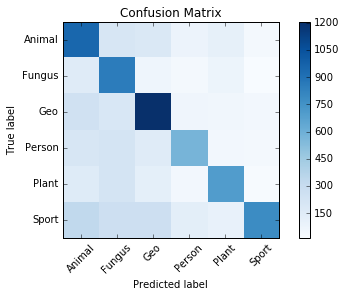

In [106]:
evaluateRepresentationWithPearsonCoeffs(X["RGB Histogram Representation"])

RGB Histogram scores well in both evaluation criteria. It is very intuitive also that classes could be predicted based solely on chromatic information.

#### HSV Histogram - Euclidean Distances

Accuracy of majority vote = 0.410370535218

Confusion Matrix:
[[487 471 267  75 194  77]
 [182 777  73  18 130  27]
 [390 351 806  79  75 107]
 [218 361 170 332  56 105]
 [181 282  84  29 669  26]
 [299 532 193  98 149 617]]


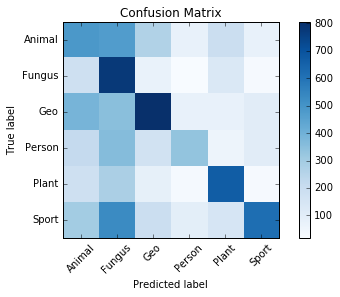

In [107]:
evaluateRepresentationWithEuclideanDistances(X["HSV Histogram Representation"])

#### HSV Histogram - Pearson Coefficients

Accuracy of majority vote = 0.58473350395

Confusion Matrix:
[[ 909  233  211   60  117   41]
 [ 151  886   69   18   69   14]
 [ 247  204 1236   44   42   35]
 [ 194  243  168  540   33   64]
 [ 142  161   97   31  822   18]
 [ 264  277  289   89  107  862]]


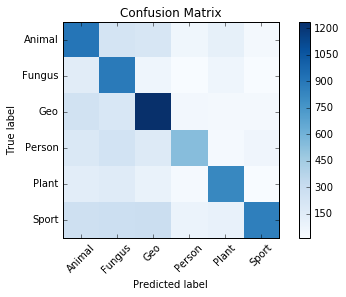

In [108]:
evaluateRepresentationWithPearsonCoeffs(X["HSV Histogram Representation"])

HSV, same as RGB produces intuitive results.

#### User Image Rating - Euclidean Distances

Accuracy of majority vote = 0.627906976744

Confusion Matrix:
[[1111   33  204   33   58  132]
 [  49  783  180   62   69   64]
 [ 282  216  805  120  122  263]
 [  48   75  126  848   63   82]
 [  82   76  150   86  820   57]
 [ 145   75  244   85   63 1276]]


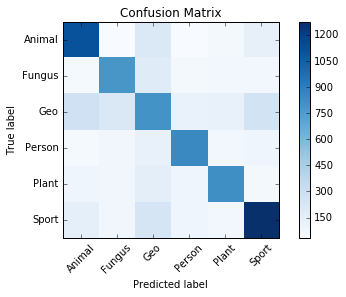

In [109]:
evaluateRepresentationWithEuclideanDistances(X["Rating Representation"])

#### User Image Rating - Pearson Coefficients

Accuracy of majority vote = 0.212863024369

Confusion Matrix:
[[ 239    1  896    0    0  435]
 [ 135    1  717    3    0  351]
 [ 193    5 1127    2    0  481]
 [ 135    5  768    3    0  331]
 [ 141    0  757    1    0  372]
 [ 242    4 1096    3    0  543]]


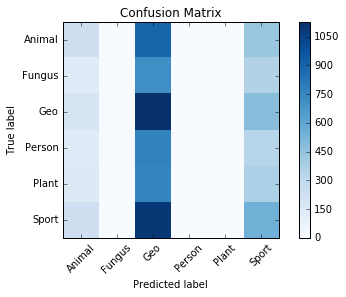

In [110]:
evaluateRepresentationWithPearsonCoeffs(X["Rating Representation"])

While generating user image rating matrix, we can choose to generate category mean in two different ways. One is creating 6 category means, one for each category and then using these means for each rating as per the category of the image that is being rated. Other method is to generate new category mean for each individual rating. Also, it can be noticed that the rating representation performs very poorly for the pearson correlation evaluation criteria.

#### Summary of accuracies

|                      |   Autoencoder  |       SVD      |  RGB Histogram |  HSV Histogram | User Image Rating |
|:--------------------:|:--------------:|:--------------:|:--------------:|:--------------:|:-----------------:|
| Euclidean Distances  | 0.277734505397 | 0.585067319461 | 0.361410926894 | 0.410370535218 |   0.627906976744  |
| Pearson Coefficients |  0.47546455992 | 0.572938689218 | 0.563480583064 |  0.58473350395 |   0.212863024369  |